In [251]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from src.models import SensingModel, HumanModel, ScheduleModel
from datetime import datetime as dt

import numpy as np
import pandas as pd

TNMModel = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Set

In [252]:
sensing_model = SensingModel()
human_model = HumanModel()
schedule_model = ScheduleModel()

In [253]:
datas_09 = pd.DataFrame(sensing_model.get_one_month(9))
datas_09.head()

,employee_name,event,start_time,end_time,score
0,직원 1,지각,2022-09-05 09:00:00,2022-09-05 09:10:00,2
1,직원 1,지각,2022-09-06 09:00:00,2022-09-06 09:05:00,2
2,직원 1,자리 이탈,2022-09-06 13:00:00,2022-09-06 13:30:00,6
3,직원 1,자리 이탈,2022-09-08 17:15:00,2022-09-08 17:55:00,8
4,직원 1,자리 이탈,2022-09-14 14:00:00,2022-09-14 14:10:00,2


### 직원 1 예제

#### 직원 1의 한달 업무성취도 데이터

In [254]:
emp_name = "직원 1"

datas_emp = datas_09[datas_09['employee_name'] == emp_name].copy()

# 시간단위 까지 나누어져 있는 개별 센싱을 날짜별로 그룹화
datas_emp['day'] = datas_emp['start_time'].dt.day
processing_datas_emp = datas_emp.groupby('day').sum()
processing_datas_emp.reset_index(inplace=True)
processing_datas_emp

,day,score
0,5,2
1,6,8
2,8,8
3,14,2
4,15,15
5,20,6
6,23,15
7,26,4


#### 직원 1의 TNM Model 도출

In [255]:
# time, 날짜가 높을수록 가장 최근에 일어난 데이터
time = processing_datas_emp['day'].max()

# number, 해당 데이터의 행 길이가 한 달 동안 미달성 센싱이 발생한 횟수
number = len(processing_datas_emp)

# magnitude, 한 달동안 취득한 미달성 점수 총합
magnitude = processing_datas_emp['score'].sum()

# 가중치 설정
time_weight = 1
number_weight = 1
magnitude_weight = 1
TNM_value = (time * time_weight) + (number * number_weight) + \
            (magnitude * magnitude_weight)

TNMModel.append({
    "employee_name": emp_name,
    "Time": time,
    "Number": number,
    "Magnitude": magnitude,
    "TNM Value": TNM_value
}, ignore_index=True)

,employee_name,Time,Number,Magnitude,TNM Value
0,직원 1,26,8,60,94


### 모든 직원에 대하여 TNM Model 도출 및 병합

In [256]:
def get_tnm(emp_name, datas ,weights=[1,1,1]):
    datas_emp = datas[datas['employee_name'] == emp_name].copy()

    # 시간단위 까지 나누어져 있는 개별 센싱을 날짜별로 그룹화
    datas_emp['day'] = datas_emp['start_time'].dt.day
    processing_datas_emp = datas_emp.groupby('day').sum()
    processing_datas_emp.reset_index(inplace=True)
    processing_datas_emp
    
    # time, 날짜가 높을수록 가장 최근에 일어난 데이터
    time = processing_datas_emp['day'].max()

    # number, 해당 데이터의 행 길이가 한 달 동안 미달성 센싱이 발생한 횟수
    number = len(processing_datas_emp)

    # magnitude, 한 달동안 취득한 미달성 점수 총합
    magnitude = processing_datas_emp['score'].sum()

    # 가중치 설정
    time_weight, number_weight, magnitude_weight = weights
    
    TNM_value = (time * time_weight) + (number * number_weight) + \
            (magnitude * magnitude_weight)

    return time * time_weight, number * number_weight, magnitude * magnitude_weight, TNM_value

In [257]:
for emp_name in ['직원 1','직원 2', '직원 3']:
    time, number, magnitude, TNM_value = get_tnm(emp_name, datas_09)
    
    TNMModel = TNMModel.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": TNM_value
    }, ignore_index=True)

In [258]:
TNMModel.set_index("employee_name", inplace=True)
TNMModel

,Time,Number,Magnitude,TNM Value
employee_name,,,,
직원 1,26,8,60,94
직원 2,30,1,2,33
직원 3,14,4,70,88


### TNM Model 정규화

In [259]:
score_table = pd.DataFrame()
target_col = ['Time', 'Number', 'Magnitude']

for col in target_col:
    col_datas = TNMModel[col].tolist()
    min_data = min(col_datas)
    max_data = max(col_datas)
    
    score_col = np.linspace(min_data, max_data, 4)
    # 소숫점 첫 째 자리까지만 살려두기
    score_col = np.round(score_col * 10) / 10
    score_table[col] = score_col

# 작거나 같으면에 점수를 부여하면 되기 때문에 최댓값은 필요없다.
score_table = score_table.iloc[:-1]
score_table.index = ['1점(우수)', '2점(미달)', '3점(매우미달)']
print("작거나 같으면에 점수 부여")
score_table['score'] = [1,2,3]
score_table

작거나 같으면에 점수 부여


,Time,Number,Magnitude,score
1점(우수),14.0,1.0,2.0,1
2점(미달),19.3,3.3,24.7,2
3점(매우미달),24.7,5.7,47.3,3


### 정규화 TNM Model

In [260]:
norm_TNMModel = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])

for emp_name, row in TNMModel.iterrows():
    time = score_table['score'][score_table['Time'] <= row['Time']][-1]
    number = score_table['score'][score_table['Number'] <= row['Number']][-1]
    magnitude = score_table['score'][score_table['Magnitude'] <= row['Magnitude']][-1]
    
    norm_tnm_value = time + number + magnitude
    norm_TNMModel = norm_TNMModel.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": norm_tnm_value
    }, ignore_index=True)

In [261]:
norm_TNMModel

,employee_name,Time,Number,Magnitude,TNM Value
0,직원 1,3,3,3,9
1,직원 2,3,1,1,5
2,직원 3,1,2,3,6


### TNM Segmentation

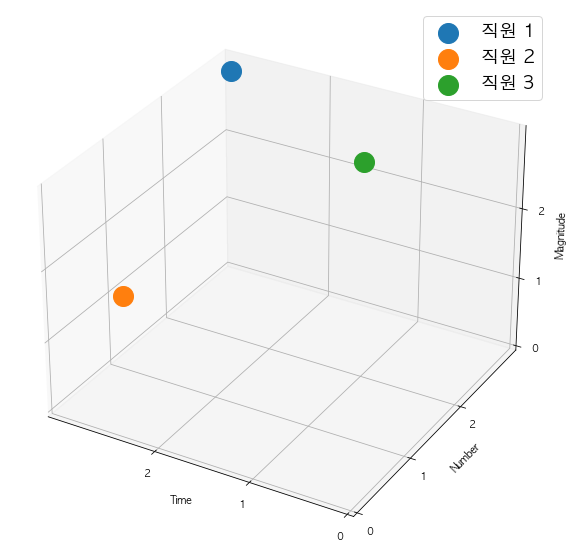

In [262]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# x - Recently, y - Frequency, z - Monetary
for idx, row in norm_TNMModel.iterrows():
    emp_name,t,n,m = row[:-1]
    ax.scatter(t,n,m, s=400, label=emp_name)
    
ax.invert_xaxis()
ax.set_xlabel('Time')
ax.set_xticks(range(0,3))
ax.set_ylabel('Number')
ax.set_yticks(range(0,3))
ax.set_zlabel('Magnitude')
ax.set_zticks(range(0,3))

plt.legend(fontsize=18)
plt.show()

### 다음달 업무평가 (개선점수 구하기) - 상대평가에 의한 문제

In [263]:
# 10월 데이터 준비
datas_10 = pd.DataFrame(sensing_model.get_one_month(10))
datas_10.head()

,employee_name,event,start_time,end_time,score
0,직원 1,지각,2022-10-07 09:00:00,2022-10-07 09:05:00,2
1,직원 1,지각,2022-10-11 09:00:00,2022-10-11 09:05:00,2
2,직원 3,지각,2022-10-03 09:00:00,2022-10-03 10:00:00,15


In [264]:
TNMModel_10 = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])
for emp_name in ['직원 1','직원 2', '직원 3']:
    time, number, magnitude, TNM_value = get_tnm(emp_name, datas_10)
    
    TNMModel_10 = TNMModel_10.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": TNM_value
    }, ignore_index=True)

TNMModel_10.fillna(0, inplace=True)
TNMModel_10.set_index("employee_name", inplace=True)
TNMModel_10

,Time,Number,Magnitude,TNM Value
employee_name,,,,
직원 1,11,2,4,17
직원 2,0,0,0,0
직원 3,3,1,15,19


In [265]:
score_table_10 = pd.DataFrame()
target_col = ['Time', 'Number', 'Magnitude']

for col in target_col:
    col_datas = TNMModel_10[col].tolist()
    min_data = min(col_datas)
    max_data = max(col_datas)
    
    score_col = np.linspace(min_data, max_data, 4)
    # 소숫점 첫 째 자리까지만 살려두기
    score_col = np.round(score_col * 10) / 10
    score_table_10[col] = score_col

# 작거나 같으면에 점수를 부여하면 되기 때문에 최댓값은 필요없다.
score_table_10 = score_table_10.iloc[:-1]
score_table_10.index = ['1점(우수)', '2점(미달)', '3점(매우미달)']
print("작거나 같으면에 점수 부여")
score_table_10['score'] = [1,2,3]
score_table_10

작거나 같으면에 점수 부여


,Time,Number,Magnitude,score
1점(우수),0.0,0.0,0.0,1
2점(미달),3.7,0.7,5.0,2
3점(매우미달),7.3,1.3,10.0,3


In [266]:
norm_TNMModel_10 = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])

for emp_name, row in TNMModel_10.iterrows():
    time = score_table_10['score'][score_table_10['Time'] <= row['Time']][-1]
    number = score_table_10['score'][score_table_10['Number'] <= row['Number']][-1]
    magnitude = score_table_10['score'][score_table_10['Magnitude'] <= row['Magnitude']][-1]
    
    norm_tnm_value = time + number + magnitude
    norm_TNMModel_10 = norm_TNMModel_10.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": norm_tnm_value
    }, ignore_index=True)

In [267]:
norm_TNMModel_10

,employee_name,Time,Number,Magnitude,TNM Value
0,직원 1,3,3,1,7
1,직원 2,1,1,1,3
2,직원 3,1,2,3,6


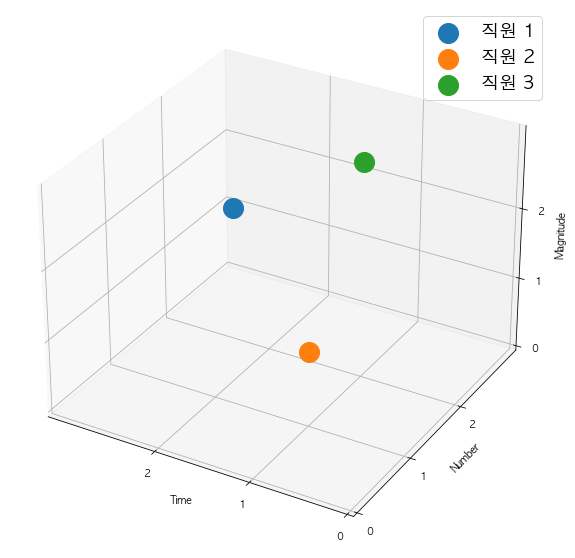

In [268]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# x - Recently, y - Frequency, z - Monetary
for idx, row in norm_TNMModel_10.iterrows():
    emp_name,t,n,m = row[:-1]
    ax.scatter(t,n,m, s=400, label=emp_name)
    
ax.invert_xaxis()
ax.set_xlabel('Time')
ax.set_xticks(range(0,3))
ax.set_ylabel('Number')
ax.set_yticks(range(0,3))
ax.set_zlabel('Magnitude')
ax.set_zticks(range(0,3))

plt.legend(fontsize=18)
plt.show()

### 개선점수를 위한 데이터 병합

In [269]:
TNMModel.index = ["{}_9월".format(_) for _ in TNMModel.index]
TNMModel

,Time,Number,Magnitude,TNM Value
직원 1_9월,26,8,60,94
직원 2_9월,30,1,2,33
직원 3_9월,14,4,70,88


In [270]:
TNMModel_10.index = ["{}_10월".format(_) for _ in TNMModel_10.index]
TNMModel_10

,Time,Number,Magnitude,TNM Value
직원 1_10월,11,2,4,17
직원 2_10월,0,0,0,0
직원 3_10월,3,1,15,19


In [271]:
TNMModel_merge = pd.concat([TNMModel, TNMModel_10])
TNMModel_merge

,Time,Number,Magnitude,TNM Value
직원 1_9월,26,8,60,94
직원 2_9월,30,1,2,33
직원 3_9월,14,4,70,88
직원 1_10월,11,2,4,17
직원 2_10월,0,0,0,0
직원 3_10월,3,1,15,19


In [272]:
score_table_merge = pd.DataFrame()
target_col = ['Time', 'Number', 'Magnitude']

for col in target_col:
    col_datas = TNMModel_merge[col].tolist()
    min_data = min(col_datas)
    max_data = max(col_datas)
    
    score_col = np.linspace(min_data, max_data, 4)
    # 소숫점 첫 째 자리까지만 살려두기
    score_col = np.round(score_col * 10) / 10
    score_table_merge[col] = score_col

# 작거나 같으면에 점수를 부여하면 되기 때문에 최댓값은 필요없다.
score_table_merge = score_table_merge.iloc[:-1]
score_table_merge.index = ['1점(우수)', '2점(미달)', '3점(매우미달)']
print("작거나 같으면에 점수 부여")
score_table_merge['score'] = [1,2,3]
score_table_merge

작거나 같으면에 점수 부여


,Time,Number,Magnitude,score
1점(우수),0.0,0.0,0.0,1
2점(미달),10.0,2.7,23.3,2
3점(매우미달),20.0,5.3,46.7,3


In [273]:
norm_TNMModel_merge = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])

for emp_name, row in TNMModel_merge.iterrows():
    time = score_table_merge['score'][score_table_merge['Time'] <= row['Time']][-1]
    number = score_table_merge['score'][score_table_merge['Number'] <= row['Number']][-1]
    magnitude = score_table_merge['score'][score_table_merge['Magnitude'] <= row['Magnitude']][-1]
    
    norm_tnm_value = time + number + magnitude
    norm_TNMModel_merge = norm_TNMModel_merge.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": norm_tnm_value
    }, ignore_index=True)

In [274]:
norm_TNMModel_merge

,employee_name,Time,Number,Magnitude,TNM Value
0,직원 1_9월,3,3,3,9
1,직원 2_9월,3,1,1,5
2,직원 3_9월,2,2,3,7
3,직원 1_10월,2,1,1,4
4,직원 2_10월,1,1,1,3
5,직원 3_10월,1,1,1,3


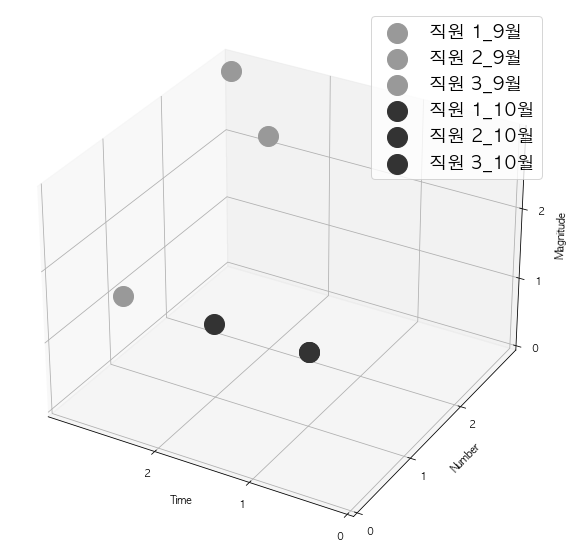

In [275]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# x - Recently, y - Frequency, z - Monetary
for idx, row in norm_TNMModel_merge.iterrows():
    emp_name,t,n,m = row[:-1]
    
    color = "#999" if "9월" in emp_name else "#333"
    ax.scatter(t,n,m, s=400, label=emp_name, color=color)
    
ax.invert_xaxis()
ax.set_xlabel('Time')
ax.set_xticks(range(0,3))
ax.set_ylabel('Number')
ax.set_yticks(range(0,3))
ax.set_zlabel('Magnitude')
ax.set_zticks(range(0,3))

plt.legend(fontsize=18)
plt.show()

In [276]:
# 개선점수
norm_TNMModel_merge.set_index("employee_name", inplace=True)
better_scores = list()

for emp_name in ['직원 1', '직원 2', '직원 3']:
    row_09 = norm_TNMModel_merge.loc["{}_9월".format(emp_name)];
    row_10 = norm_TNMModel_merge.loc["{}_10월".format(emp_name)];
    
    better_score = np.sqrt(((row_09[:-1] - row_10[:-1]) ** 2).sum()) 
    # 첫 째 자리 까지만 살려두기
    better_score = round(better_score * 10) / 10
    
    better_scores.append(better_score)
TNMModel_10['개선점수'] = better_scores
TNMModel_10

,Time,Number,Magnitude,TNM Value,개선점수
직원 1_10월,11,2,4,17,3.0
직원 2_10월,0,0,0,0,2.0
직원 3_10월,3,1,15,19,2.4


### 가중치의 의미

In [279]:
TNMModel_weights = pd.DataFrame(columns=['employee_name', 'Time', 'Number', 'Magnitude', 'TNM Value'])

for emp_name in ['직원 1','직원 2', '직원 3']:
    time, number, magnitude, TNM_value = get_tnm(emp_name, datas_09, weights=[0.5,1,2])
    
    TNMModel_weights = TNMModel_weights.append({
        "employee_name": emp_name,
        "Time": time,
        "Number": number,
        "Magnitude": magnitude,
        "TNM Value": TNM_value
    }, ignore_index=True)

In [280]:
TNMModel_weights

,employee_name,Time,Number,Magnitude,TNM Value
0,직원 1,13.0,8,120,141.0
1,직원 2,15.0,1,4,20.0
2,직원 3,7.0,4,140,151.0


In [250]:
TNMModel

,Time,Number,Magnitude,TNM Value
직원 1_9월,26,8,60,94
직원 2_9월,30,1,2,33
직원 3_9월,14,4,70,88
